In [1]:
from datetime import datetime, date
import pandas as pd
import numpy as np
from scipy import stats
import re, os, nltk, math, csv, json
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Google Drive - This will prompt you to click a link to authorize
# (don't execute if running on own machine)
from google.colab import drive, auth, files
from oauth2client.client import GoogleCredentials
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Google Drive - Navigate to directory
# (don't execute if running on own machine)
os.chdir('drive/MyDrive/SocialComQuant22/')
os.listdir('.')

['Data',
 'Resources_geolocation',
 'Resources_nutrition',
 'Obesity.ipynb',
 'Resources_sentiment',
 'MentalHealth.ipynb']

# NLP for health -- case study of Eating Disorders 

Sometimes we want to understand the linguistic features of a group, compared to some other group, and summarize the content of their discussion.

1. Difference in word frequency using Odds Ratio
2. Exploring topics using co-occurrence networks
3. Linguistic analysis using LIWC

In [2]:
# Read in tweets posted around anorexia in before and during COVID lockdowns
tweets_beforeCOVID = pd.read_csv("Data/anorexic_2020_jan_feb_text.tsv", sep="\t", lineterminator='\n',
                  low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
                  names=["text", "id"], dtype={'id': object})
tweets_duringCOVID = pd.read_csv("Data/anorexic_2020_apr_may_text.tsv", sep="\t", lineterminator='\n',
                  low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
                  names=["text", "id"], dtype={'id': object})

In [3]:
print(tweets_beforeCOVID.shape)
print(tweets_duringCOVID.shape)

(15727, 2)
(12561, 2)


In [4]:
pd.options.display.max_colwidth = 1000
tweets_beforeCOVID.sample(5)

,text,id
6792,Eating disorders have the highest mortality rate of any mental illness. No one ever talks about them and they are not taken seriously whatsoever. I am an anorexia survivor and I’m not ashamed of it. #BellLetsTalk,1222549040614793216
14860,"🥕TW🥕tbh theres no such thing as weight/fat that u cant lose. ur just not losing it bc u keep stuffing ur face w food. as long as ur not eating, theres rlly no excuse for u to not lose weight/fat. (this is more like a note-to-self thing &amp; is NOT a proana acc) #thinspo #edtwt https://t.co/Bs0Dk6hVKa",1232683409115418625
8800,@AltAvenged I know 😭 trust me I know and I wanna stop. I wanna be normal again. I fucking hate anorexia. I thought I beat. I thought I was over it. But here we are.,1222921243806126081
7818,Eating disorders have the highest mortality rate of any mental illness. No one ever talks about them and they are not taken seriously whatsoever. I am an anorexia survivor and I’m not ashamed of it. #BellLetsTalk,1222605832593997827
4167,"I smashed my scale that I had through the majority of my time before recovering from anorexia!! I cut you out of my life, bitch!!",1219066009958723585


## 2.1 Most distinguishing terms

Odds ratio is a measure that quantifies the strength of the association between two events, A and B. We want to know, how likely is a word to occur, given we are looking at tweets during COVID, compared to before COVID?

More on odds ratio: https://en.wikipedia.org/wiki/Odds_ratio

### Text pre-processing

In [5]:
# Function to clean the text
re_url = re.compile(r'https?:\/\/.*[\r\n]*', flags=re.U)
re_rtw = re.compile(r'RT', flags=re.U)
re_htg = re.compile(r'#', flags=re.U) # remove hashtag sign
#re_htg = re.compile(r'#[\w]+ ?', flags=re.U)   # remove hashtags
re_hnd = re.compile(r'@\w+ ?', flags=re.U)
re_wrd = re.compile(r'[^\w]+ ', flags=re.U)
re_num = re.compile(r'[0-9]+', flags=re.U)

def cleantext(txt):
    t = txt
    t = re_url.sub('', t)
    t = re_htg.sub('', t)
    t = re_rtw.sub(' ', t)
    t = re_hnd.sub(' ', t)
    t = re_wrd.sub(' ', t)
    t = re_num.sub(' ', t)
    
    return t.strip().lower()

In [6]:
# Clean the text
tweets_beforeCOVID["text_clean"] = tweets_beforeCOVID.text.apply(lambda x: cleantext(x))
tweets_duringCOVID["text_clean"] = tweets_duringCOVID.text.apply(lambda x: cleantext(x))

In [7]:
tweets_beforeCOVID.sample(5)

,text,id,text_clean
1205,I was diagnosed with anorexia a few years back whenever I was like ten and it got worse but I just wanted to let y’all know so you all won’t freak out if I’m not active I love you all and I will be keeping in touch and giving updates I’ll try to come on Twitter atleast,1214466484531019781,i was diagnosed with anorexia a few years back whenever i was like ten and it got worse but i just wanted to let y’all know so you all won’t freak out if i’m not active i love you all and i will be keeping in touch and giving updates i’ll try to come on twitter atleast
2313,my bpd and anorexia when i’m just trying to have a good time https://t.co/TJOdWjSjsg,1215791024896868353,my bpd and anorexia when i’m just trying to have a good time
751,"1) Was in the schools Irish national finals for swimming. 2) Used to have really bad anorexia. 3) Supported Liverpool all my life. 4) Parents tried to get me tested for ADHD twice but they refused bc I was in a top school, got kicked out with the lowest grades 3 years later.",1213790273165254656,was in the schools irish national finals for swimming used to have really bad anorexia supported liverpool all my life parents tried to get me tested for adhd twice but they refused bc i was in a top school got kicked out with the lowest grades years later.
9097,I'm a19 yo female I've been diagnosed with Anorexia Nervosa. There isn't any eating disorder centers in Sudan Psychiatrists are with little to no expert regarding this category And CVS complications that showed lately put me at a higher risk of sudden heart stop. Help please,1223289953804849152,i'm a yo female i've been diagnosed with anorexia nervosa there isn't any eating disorder centers in sudan psychiatrists are with little to no expert regarding this category and cvs complications that showed lately put me at a higher risk of sudden heart stop help please
6663,Eating disorders have the highest mortality rate of any mental illness. No one ever talks about them and they are not taken seriously whatsoever. I am an anorexia survivor and I’m not ashamed of it. #BellLetsTalk,1222544117911244800,eating disorders have the highest mortality rate of any mental illness no one ever talks about them and they are not taken seriously whatsoever i am an anorexia survivor and i’m not ashamed of it bellletstalk


In [8]:
# Remove duplicates after cleaning
tweets_beforeCOVID = tweets_beforeCOVID.drop_duplicates("text_clean")
tweets_duringCOVID = tweets_duringCOVID.drop_duplicates("text_clean")

In [9]:
# Tokenize the text
tokenizer = RegexpTokenizer(r'\w+')
tweets_beforeCOVID["text_tokens"] = tweets_beforeCOVID["text_clean"].apply(lambda x: tokenizer.tokenize(x))
tweets_beforeCOVID = tweets_beforeCOVID.dropna(subset=['text_tokens'])
tweets_duringCOVID["text_tokens"] = tweets_duringCOVID["text_clean"].apply(lambda x: tokenizer.tokenize(x))
tweets_duringCOVID = tweets_duringCOVID.dropna(subset=['text_tokens'])

In [10]:
tweets_beforeCOVID.sample(5)

,text,id,text_clean,text_tokens
11668,"""""""""""""""The only person allowed to be mean to My Sister was Me! Oh Hell No!"""""""" I was rather emotionally unstable. Mother's Death was Devastating. I was doing this for Her. As I recall, I stayed about 5 weeks on that particular visit. 1st bout of Anorexia surfaced soon thereafter.""""""",1226824115576823809,"""""""""""""""the only person allowed to be mean to my sister was me oh hell no i was rather emotionally unstable mother's death was devastating i was doing this for her as i recall i stayed about weeks on that particular visit st bout of anorexia surfaced soon thereafter.""""""","[the, only, person, allowed, to, be, mean, to, my, sister, was, me, oh, hell, no, i, was, rather, emotionally, unstable, mother, s, death, was, devastating, i, was, doing, this, for, her, as, i, recall, i, stayed, about, weeks, on, that, particular, visit, st, bout, of, anorexia, surfaced, soon, thereafter]"
4546,"I would like to take credit for curing my moms ed She was a die hard, og proana in the 80s and 90s, but then she got pregnant and it was either recover or lose me",1219706233298571264,i would like to take credit for curing my moms ed she was a die hard og proana in the s and s but then she got pregnant and it was either recover or lose me,"[i, would, like, to, take, credit, for, curing, my, moms, ed, she, was, a, die, hard, og, proana, in, the, s, and, s, but, then, she, got, pregnant, and, it, was, either, recover, or, lose, me]"
3223,"The evolution of my ed has basically been “oh hi I’m going to be orthorexia nice to- I mean binge eating disorder, no anorexia, no wait I think I’ll be buli- oh you got tired of doing one extreme? Fine let’s do all extremes, ednos it is”",1217549503852613635,the evolution of my ed has basically been “oh hi i’m going to be orthorexia nice to i mean binge eating disorder no anorexia no wait i think i’ll be buli oh you got tired of doing one extreme fine let’s do all extremes ednos it is”,"[the, evolution, of, my, ed, has, basically, been, oh, hi, i, m, going, to, be, orthorexia, nice, to, i, mean, binge, eating, disorder, no, anorexia, no, wait, i, think, i, ll, be, buli, oh, you, got, tired, of, doing, one, extreme, fine, let, s, do, all, extremes, ednos, it, is]"
1903,to jillian michaels workout videos for the 3rd time in a day at 2 am and spiriling into anorexia i could have been celebrating my body for what it was and who I was,1215293581130227712,to jillian michaels workout videos for the rd time in a day at am and spiriling into anorexia i could have been celebrating my body for what it was and who i was,"[to, jillian, michaels, workout, videos, for, the, rd, time, in, a, day, at, am, and, spiriling, into, anorexia, i, could, have, been, celebrating, my, body, for, what, it, was, and, who, i, was]"
57,First 2020 goal is to control my anorexia,1212224711981195264,first goal is to control my anorexia,"[first, goal, is, to, control, my, anorexia]"


In [11]:
# Create a frequency table for each dataset
c_before = Counter(tokenizer.tokenize(tweets_beforeCOVID["text_clean"].str.cat(sep=' ')))
c_during = Counter(tokenizer.tokenize(tweets_duringCOVID["text_clean"].str.cat(sep=' ')))
counts_before = pd.DataFrame(list(dict(c_before.most_common()).items()), columns=["word","cnt_before"])
counts_during = pd.DataFrame(list(dict(c_during.most_common()).items()), columns=["word","cnt_during"])

In [12]:
# Top words in tweets before COVID
counts_before.head(10)

,word,cnt_before
0,i,13212
1,and,5922
2,my,5906
3,to,5812
4,anorexia,5537
5,a,3750
6,the,3130
7,it,3080
8,me,2874
9,of,2814


In [13]:
# Top words in tweets during COVID
counts_during.head(10)

,word,cnt_during
0,i,13934
1,and,6444
2,my,6230
3,to,5939
4,anorexia,5766
5,a,3889
6,me,3308
7,the,3218
8,it,3214
9,of,2888


In [14]:
# Remove stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
stop.append("amp")
stop.append("rt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ymejova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
counts_before = counts_before[~counts_before.word.isin(stop)]
counts_during = counts_during[~counts_during.word.isin(stop)]

In [16]:
# Top words in tweets before COVID
counts_before.head(10)

,word,cnt_before
4,anorexia,5537
25,like,1208
32,eating,925
34,weight,846
42,years,727
47,get,634
51,ed,571
55,life,529
57,want,517
60,know,507


In [17]:
# Top words in tweets during COVID
counts_during.head(10)

,word,cnt_during
4,anorexia,5766
24,like,1438
31,eating,1007
33,weight,987
39,years,823
45,proana,721
46,ed,699
50,get,614
54,eat,593
56,time,575


### Top used words during COVID by odds ratio

Probability is the probability an event happens. For example, there might be an 80% chance of rain today.

Odds (more technically the odds of success) is defined as probability of success/probability of failure. So the odds of a success (80% chance of rain) has an accompanying odds of failure (20% chance it doesn’t rain); as an equation (the “odds ratio“), that’s .8/.2 = 4.

Log odds is the logarithm of the odds. Ln(4) = 1.38629436 ≅ 1.386.

Conversion to log odds results in symmetry around zero, which is easier for analysis.

For more, see https://www.statisticshowto.com/log-odds/

Definition from Wikipedia https://en.wikipedia.org/wiki/Odds_ratio

w = word, 
n = not word, 
d = during COVID, 
b = before COVID

```
      w    n
d    pwd  pnd
b    pwb  pnb

     pwd pnb
OR = -------
     pnd pwb
```

In [18]:
# Put together the vocabularies from both datasets
wordtable = pd.merge(counts_during, counts_before, on="word", how="outer").fillna(0)
wordtable.shape

(14639, 3)

In [19]:
# Compute counts of other words for each word
wordtable["cnt_before_not"] = wordtable.cnt_before.sum() - wordtable["cnt_before"]
wordtable["cnt_during_not"] = wordtable.cnt_during.sum() - wordtable["cnt_during"]

In [20]:
wordtable[wordtable.word=="covid"]

,word,cnt_during,cnt_before,cnt_before_not,cnt_during_not
581,covid,33.0,0.0,99989.0,107983.0


In [21]:
# Compute the odds ratio
wordtable["oddsratio"] = ((wordtable['cnt_during']+1) * wordtable['cnt_before_not']) / ((wordtable['cnt_before']+1) * wordtable['cnt_during_not'])
wordtable["logoddsratio"] = wordtable["oddsratio"].apply(lambda x: math.log(x))

In [22]:
# Sort the words by odds ratio
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable.head(20)

,word,cnt_during,cnt_before,cnt_before_not,cnt_during_not,oddsratio,logoddsratio
222,hiya,89.0,0.0,99989.0,107927.0,83.380526,4.423415
224,cards,89.0,0.0,99989.0,107927.0,83.380526,4.423415
246,quarantine,81.0,0.0,99989.0,107935.0,75.963293,4.330250
581,covid,33.0,0.0,99989.0,107983.0,31.482974,3.449447
670,lockdown,27.0,0.0,99989.0,107989.0,25.925715,3.255235
827,madisonbeerlisteningparty,22.0,0.0,99989.0,107994.0,21.295137,3.058479
223,football,89.0,3.0,99986.0,107927.0,20.844506,3.037090
937,ramadan,19.0,0.0,99989.0,107997.0,18.516996,2.918689
1020,scares,17.0,0.0,99989.0,107999.0,16.664988,2.813310
985,pandemic,17.0,0.0,99989.0,107999.0,16.664988,2.813310


In [23]:
# Look at examples of word use
tweets_duringCOVID.loc[tweets_duringCOVID.text_clean.str.contains("quarantine"), "text"].sample(10)

4101                                                                                                                                                                                         tw//ed  years of anorexia and i’m only pretty during quarantine when i’ve gained too many pounds to count. sexy.
1939                                                                                                                                                           get me OUT OF QUARANTINE block me from certain communities and tags i can't take it djjcchxxh h i keep looking at proana tags i'm gonna go mad
1                                                                                                                                                                                                        does anyone wanna be in a quarantine proana gc? Like/rt to join!   #thinspo #proana #skinny #meanspo
7472                                                                                          

In [24]:
# Look at examples of word use
tweets_duringCOVID.loc[tweets_duringCOVID.text_clean.str.contains("ramadan"), "text"].sample(10)

11735                                                                                                                                                                                                                               """""""OH MY GODDDDD DO U KNOW I DID RAMADAN THIS YEAR?W&gt;@!!?""""   No becky its anorexia"""
2529                                                 Tw:// eating disorder  I love how my parents have to check that I’m having a proper suhoor when I’m fasting because I have a tendency to just not and my anorexia literally started during Ramadan like on top of not eating during the day I ate barely anything after sunset
5677                                                                                                                                                                                                                                               Every Ramadan my white cousin makes the same anorexia joke in our fam group chat
3890                        

In [25]:
# Look at examples of word use
tweets_duringCOVID.loc[tweets_duringCOVID.text_clean.str.contains("cards"), "text"].sample(10)

4176               @ClinganS Hiya Sammy just wondering if you could sign a couple of football cards for me as i have been trying for 7 years it’s ok if not I suffer with anorexia nervosa and was wondering if you could help me in this dark time stay safe thank you https://t.co/TaQZCVI5A3
4716              @KJMonkou Hiya Kenny just wondering if you could sign a couple of football cards for me as i have been trying for 13 years it’s ok if not I suffer with anorexia nervosa and was wondering if you could help me in this dark time stay safe thank you https://t.co/tLg8SrSQqb
4180           @KGDikgacoi Hiya Kagisho just wondering if you could sign a couple of football cards for me as i have been trying for 7 years it’s ok if not I suffer with anorexia nervosa and was wondering if you could help me in this dark time stay safe thank you https://t.co/Na2DW9DeTt
4700           @NigelWinty3 Hiya Nigel just wondering if you could sign a couple of football cards for me as i have been trying for 13 y

In [26]:
# Look at examples of word use
tweets_duringCOVID.loc[tweets_duringCOVID.text_clean.str.contains("hiya"), "text"].sample(10)

12383                                  @vince_bartram Hiya Vince just wondering if you could sign a couple of football cards for me as i have been trying for 7 years it’s ok if not I suffer with anorexia nervosa and was wondering if you could help me in this dark time stay safe thank you
4394                 @SNewts7 Hiya Shaun just wondering if you could sign a couple of football cards for me as i have been trying for 7 years it’s ok if not I suffer with anorexia nervosa and was wondering if you could help me in this dark time stay safe thank you https://t.co/oYyQ0UCdw0
12407    @SueJones19 Hiya Sue just wondering if you could pass a message on to rob for me to sign a couple of football cards for me as i have been trying for 7 years it’s ok if not I suffer with anorexia nervosa and was wondering if you could help me in this dark time stay safe thank you
4167             @Keith_Fahey Hiya Keith just wondering if you could sign a couple of football cards for me as i have been trying for

In [27]:
# Look at examples of word use
tweets_duringCOVID.loc[tweets_duringCOVID.text_clean.str.contains("trigger"), "text"].sample(10)

5821                                                                                                                                                                                                                   @Gothmilkymommy almond cake triggers my anorexia but if we can do almond chocolate halo top i’m in
3689                                   tw !! ed  why is there so much anorexia bs on my tl?? it’s not that fucking hard to at least put trigger warnings when talking about ed related shit. some people are already really fucking struggling and trying not to relapse during quarantine so please don’t make it harder
126                                          tw / eating disorders, body image  someone i was following (who i quickly unf) retweeted from an ed account and i ended up looking at a tag filled with proana posts from people who are a part of ‘ed twt’ and it was the single most triggering thing i’ve seen in months.
10592                                                     

### Visualize the words

In [28]:
# Import libraries for wordcloud visualization
from wordcloud import WordCloud
#from matplotlib import cm
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs): return "hsl(0, 0%%, %d%%)" % random.randint(0, 5)

In [29]:
# Prepare data
d = {}
s = wordtable.head(30)
s = s[s.word!="hiya"]
s = s[s.word!="cards"]
for i, x in s.iterrows():
    d[x["word"]] = x["oddsratio"] 

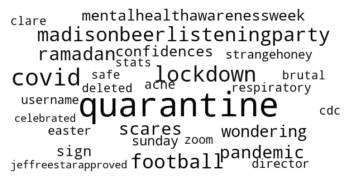

In [30]:
wordcloud = WordCloud(background_color = "white", color_func=grey_color_func, max_font_size = 60, prefer_horizontal = 1.0, width=600, height=300)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 2.2 Text summarization/exploration with word co-ccurence networks

Say, we want to understand better what words are associated with triggers. We can find the words most associated with triggers.



### Compare words in trigger to non-trigger tweets

In [31]:
# Find tweets that mention a "trigger"
tweets_trigger = pd.concat([tweets_beforeCOVID[tweets_beforeCOVID.text_clean.str.contains("trigger")], 
                            tweets_duringCOVID[tweets_duringCOVID.text_clean.str.contains("trigger")]])
tweets_trigger.shape

(407, 4)

In [32]:
wordfreq_trigger = pd.DataFrame(list(dict(Counter(tokenizer.tokenize(tweets_trigger.text_clean.str.cat(sep=' '))).most_common()).items()), columns=["word","cnt_trigger"])
wordfreq_trigger = wordfreq_trigger[~wordfreq_trigger.word.isin(stop)]
wordfreq_trigger.head(10)

,word,cnt_trigger
4,anorexia,364
15,trigger,147
21,triggered,123
26,triggering,105
29,eating,88
32,like,83
35,ed,74
41,weight,57
43,get,54
46,proana,52


In [33]:
# Find tweets that DO NOT mention a "trigger"
tweets_baseline = pd.concat([tweets_beforeCOVID[~tweets_beforeCOVID.text_clean.str.contains("trigger")], 
                             tweets_duringCOVID[~tweets_duringCOVID.text_clean.str.contains("trigger")]])
tweets_baseline.shape

(11566, 4)

In [34]:
wordfreq_baseline = pd.DataFrame(list(dict(Counter(tokenizer.tokenize(tweets_baseline.text_clean.str.cat(sep=' '))).most_common()).items()), columns=["word","cnt_baseline"])
wordfreq_baseline = wordfreq_baseline[~wordfreq_baseline.word.isin(stop)]
wordfreq_baseline.head(10)

,word,cnt_baseline
4,anorexia,10939
24,like,2563
32,eating,1844
33,weight,1776
42,years,1506
47,ed,1196
48,get,1194
53,proana,1114
55,eat,1066
58,time,1035


In [35]:
# Use odds ratio to find words most associated with "trigger"
wordtable = pd.merge(wordfreq_trigger, wordfreq_baseline, on="word", how="outer").fillna(0)
wordtable["cnt_trigger_not"] = wordtable.cnt_trigger.sum() - wordtable["cnt_trigger"]
wordtable["cnt_baseline_not"] = wordtable.cnt_baseline.sum() - wordtable["cnt_baseline"]
wordtable["oddsratio"] = ((wordtable['cnt_trigger']+1) * wordtable['cnt_baseline_not']) / ((wordtable['cnt_baseline']+1) * wordtable['cnt_trigger_not'])
wordtable["logoddsratio"] = wordtable["oddsratio"].apply(lambda x: math.log(x))
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable.head(20)

,word,cnt_trigger,cnt_baseline,cnt_trigger_not,cnt_baseline_not,oddsratio,logoddsratio
1,trigger,147.0,0.0,7297.0,200561.0,4067.839934,8.310867
2,triggered,123.0,0.0,7321.0,200561.0,3397.017347,8.130653
3,triggering,105.0,0.0,7339.0,200561.0,2896.779670,7.971355
10,triggers,50.0,0.0,7394.0,200561.0,1383.366378,7.232275
182,warnings,7.0,1.0,7437.0,200560.0,107.871454,4.680940
469,choc,3.0,0.0,7441.0,200561.0,107.814003,4.680408
887,witchcraft,2.0,0.0,7442.0,200561.0,80.849637,4.392591
612,confiding,2.0,0.0,7442.0,200561.0,80.849637,4.392591
691,aba,2.0,0.0,7442.0,200561.0,80.849637,4.392591
697,oomfs,2.0,0.0,7442.0,200561.0,80.849637,4.392591


In [36]:
# There are many words that occur very few times, let's give a frequency constraint
freq = 2
wordtable[wordtable.cnt_trigger>freq].sort_values(by = "oddsratio", ascending=False).head(20)

,word,cnt_trigger,cnt_baseline,cnt_trigger_not,cnt_baseline_not,oddsratio,logoddsratio
1,trigger,147.0,0.0,7297.0,200561.0,4067.839934,8.310867
2,triggered,123.0,0.0,7321.0,200561.0,3397.017347,8.130653
3,triggering,105.0,0.0,7339.0,200561.0,2896.779670,7.971355
10,triggers,50.0,0.0,7394.0,200561.0,1383.366378,7.232275
182,warnings,7.0,1.0,7437.0,200560.0,107.871454,4.680940
469,choc,3.0,0.0,7441.0,200561.0,107.814003,4.680408
225,yoghurt,6.0,2.0,7438.0,200559.0,62.916241,4.141804
472,cop,3.0,1.0,7441.0,200560.0,53.906733,3.987255
546,alphabet,3.0,1.0,7441.0,200560.0,53.906733,3.987255
452,sickening,3.0,1.0,7441.0,200560.0,53.906733,3.987255


In [37]:
# Remove 1 letter entries
wordtable = wordtable[wordtable.word.str.len() > 1]

In [38]:
# Let's select few top ones as "words of interest"
words_of_interest = list(wordtable[wordtable.cnt_trigger>freq].sort_values(by = "oddsratio", ascending=False).head(50).word)
words_of_interest

['trigger',
 'triggered',
 'triggering',
 'triggers',
 'warnings',
 'choc',
 'yoghurt',
 'cop',
 'alphabet',
 'sickening',
 'warning',
 'purposefully',
 'minding',
 'actor',
 'smoked',
 'documentaries',
 'chunky',
 'potentially',
 'muted',
 'unnecessary',
 'trending',
 'discuss',
 'genetic',
 'fyp',
 'sending',
 'smoking',
 'vids',
 'movie',
 'sh',
 'watch',
 'zero',
 'nutrition',
 'myproana',
 'recommended',
 'bathroom',
 'irl',
 'quick',
 'tiktok',
 'ramadan',
 'obsessive',
 'opened',
 'business',
 'remind',
 'hurting',
 'extremely',
 'unfollow',
 'deleted',
 'report',
 'caught',
 'avoid']

In [39]:
words_of_interest_weight = wordtable[wordtable.cnt_trigger>freq].sort_values(by = "oddsratio", ascending=False).head(50)[["word", "cnt_trigger"]]
words_of_interest_weight = dict(zip(words_of_interest_weight.word, words_of_interest_weight.cnt_trigger))
words_of_interest_weight

{'trigger': 147.0,
 'triggered': 123.0,
 'triggering': 105.0,
 'triggers': 50.0,
 'warnings': 7.0,
 'choc': 3.0,
 'yoghurt': 6.0,
 'cop': 3.0,
 'alphabet': 3.0,
 'sickening': 3.0,
 'warning': 36.0,
 'purposefully': 3.0,
 'minding': 4.0,
 'actor': 3.0,
 'smoked': 3.0,
 'documentaries': 3.0,
 'chunky': 3.0,
 'potentially': 3.0,
 'muted': 5.0,
 'unnecessary': 3.0,
 'trending': 3.0,
 'discuss': 3.0,
 'genetic': 3.0,
 'fyp': 4.0,
 'sending': 4.0,
 'smoking': 3.0,
 'vids': 4.0,
 'movie': 6.0,
 'sh': 3.0,
 'watch': 19.0,
 'zero': 3.0,
 'nutrition': 5.0,
 'myproana': 3.0,
 'recommended': 3.0,
 'bathroom': 3.0,
 'irl': 6.0,
 'quick': 5.0,
 'tiktok': 9.0,
 'ramadan': 3.0,
 'obsessive': 3.0,
 'opened': 3.0,
 'business': 6.0,
 'remind': 5.0,
 'hurting': 3.0,
 'extremely': 12.0,
 'unfollow': 3.0,
 'deleted': 3.0,
 'report': 3.0,
 'caught': 3.0,
 'avoid': 3.0}

### Calculate word co-occurrence

In [40]:
# To calculate the co-occurrence of words in the tweets about triggers
# First, create a frequency vector for each document:
count_model = CountVectorizer(ngram_range=(1,1)) # considering unigrams only
X = count_model.fit_transform(tweets_trigger.text_clean)
X

<407x2232 sparse matrix of type '<class 'numpy.int64'>'
	with 12130 stored elements in Compressed Sparse Row format>

In [41]:
# Compute a co-occurrence matrix 
cooc = (X.T * X) 
# Set same word cooccurence to 0
cooc.setdiag(0) 
# Print in dense format
print(cooc.todense()) 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [42]:
# Mapping between words and rows/columns in coocurrence matrix
count_model.vocabulary_

{'am': 84,
 'pro': 1442,
 'recovery': 1530,
 'have': 852,
 'anorexia': 96,
 'currently': 431,
 'struggling': 1813,
 'posting': 1421,
 'thinspo': 1936,
 'for': 719,
 'my': 1236,
 'own': 1345,
 'personal': 1382,
 'use': 2076,
 'seriously': 1660,
 'don': 534,
 'follow': 714,
 'if': 932,
 'triggering': 2009,
 'you': 2220,
 'stay': 1789,
 'safe': 1605,
 'loves': 1114,
 'deserve': 477,
 'food': 718,
 'today': 1968,
 'is': 980,
 'worth': 2192,
 'it': 988,
 'auntie': 149,
 'reqlly': 1560,
 'said': 1607,
 'im': 942,
 'skinny': 1718,
 'but': 278,
 'not': 1275,
 'that': 1909,
 'was': 2116,
 'so': 1739,
 'whos': 2158,
 'gonna': 795,
 'tell': 1888,
 'ha': 826,
 'why': 2160,
 'the': 1911,
 'fuckjjeiajjwbwhw': 748,
 'me': 1151,
 'searching': 1635,
 'meanspo': 1156,
 'to': 1967,
 'trigger': 2006,
 'vs': 2101,
 'when': 2147,
 'proana': 1443,
 'sends': 1653,
 'since': 1700,
 'camhs': 291,
 'trending': 2003,
 'been': 187,
 'in': 948,
 'from': 742,
 'over': 1339,
 'year': 2212,
 'swear': 1851,
 'come': 35

In [43]:
# Select only rows and columns we're interested in
items_of_interest = [count_model.vocabulary_[x] for x in words_of_interest]
items_of_interest

[2006,
 2008,
 2009,
 2010,
 2115,
 334,
 2219,
 397,
 78,
 1689,
 2114,
 1471,
 1190,
 27,
 1732,
 528,
 339,
 1424,
 1233,
 2065,
 2003,
 507,
 772,
 761,
 1652,
 1733,
 2091,
 1222,
 1666,
 2119,
 2230,
 1288,
 1238,
 1525,
 170,
 977,
 1484,
 1957,
 1493,
 1294,
 1323,
 277,
 1550,
 926,
 647,
 2054,
 465,
 1555,
 304,
 154]

In [44]:
# Select co-occurrences that are interested in
cooc_of_interest = cooc.todense()[items_of_interest,:][:,items_of_interest]
cooc_of_interest.shape

(50, 50)

In [45]:
cooc_of_interest

matrix([[0, 5, 3, ..., 2, 0, 1],
        [5, 0, 3, ..., 0, 3, 1],
        [3, 3, 0, ..., 1, 0, 0],
        ...,
        [2, 0, 1, ..., 0, 0, 0],
        [0, 3, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0]])

### Plot co-occurrence networks

In [46]:
# Make a table of all co-occurrences that are not 0
nonzero_coocs = list(zip(cooc_of_interest.nonzero()[0], cooc_of_interest.nonzero()[1]))
cooc_table = pd.DataFrame({"from": [words_of_interest[x] for x in cooc_of_interest.nonzero()[0]],
                           "to": [words_of_interest[x] for x in cooc_of_interest.nonzero()[1]],
                           "weight": [cooc_of_interest[x,y] for (x,y) in nonzero_coocs]})
cooc_table.sort_values(by="weight", ascending=False)

,from,to,weight
153,warning,trigger,35
6,trigger,warning,35
55,triggered,watch,9
281,watch,triggered,9
374,extremely,triggering,8
...,...,...,...
66,triggered,remind,1
63,triggered,obsessive,1
62,triggered,ramadan,1
275,sh,warnings,1


In [47]:
with open("Data/trigger_cooc.graphml", 'w') as f:
    # Header
    f.write('<?xml version="1.0" encoding="UTF-8"?>\n' + 
            '<graphml xmlns="http://graphml.graphdrawing.org/xmlns"\n' + 
            '    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"\n' + 
            '    xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns\n' + 
            '    http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">\n' + 
            '<key id="n_label" for="node" attr.name="label" attr.type="string"/>\n' + 
            '<key id="n_count" for="node" attr.name="count" attr.type="double"/>\n' + 
            '<key id="e_weight" for="edge" attr.name="weight" attr.type="double"/>\n' + 
            '<graph id="G" edgedefault="undirected">\n')
    
    # Nodes
    for i in range(len(words_of_interest)):
        f.write('<node id="' + str(i) + '">\n' +
               ' <data key="n_label">' + words_of_interest[i] + '</data>\n' +
               ' <data key="n_count">' + str(words_of_interest_weight[words_of_interest[i]]) + '</data>\n' +
               '</node>\n')
        
    # Edges
    for pair in nonzero_coocs:
        f.write('<edge source="' + str(pair[0]) + '" target="' + str(pair[1]) + '">\n' + 
                ' <data key="e_weight">' + str(math.log(cooc_of_interest[pair]+1)) + '</data>\n' +  # applying a log transform to dampen the distribution : math.log()
                '</edge>\n')
        
    # Footer
    f.write("</graph>\n</graphml>\n")

Download the trigger_cooc.graphml file and open in using Gephi (https://gephi.org/).

Try these steps (in Overview pane):
1. In Layout, select ForceAtlas 2, click Run - this will position the nodes such that most connected ones are closer together
2. In Layout, select Expansion, run it a couple of times - this will push the nodes out so they more spread out
3. Open bottom panel and click on Labels, and tick Node - this will put the textual labels on the nodes
4. Back in Layout, select Label adjust and run it - this will adjust the node positioning so the labels are not overlapping
5. In Appearance, select node size (circles), then Ranking, then count, and click Apply - this will resize the nodes by the word count associated with each word
6. Click on Preview and hit Refresh. Useful options to explore are:
  * Edge Opacity
  * Node Opacity
  * Node Labels - Font (size)
7. Save the graph as a file by clicking on Export: SVG/PDF/PNG and saving it

The output could be something like Data/trigger_cooc.png

## 2.3 Linguistic analysis with external resources: LIWC

Linguistic Inquiry and Word Count (LIWC; pronounced "Luke") a program that counts the number of words that fall into one or more linguistic, psychological and topical categories indicating various social, cognitive, and affective processes. The latest version is for sale, but the earlier versions of the dictionary exist (see Resources_sentiment folder). For more: https://www.liwc.app/

Liwc categories:

| | | | |
|-|-|-|-|
| 1	function | 19	interrog | 37	tentat | 55	focuspast |
| 2	pronoun | 20	number | 38	certain | 56	focuspresent |
| 3	ppron | 21	quant | 39	differ | 57	focusfuture |
| 4	i | 22	affect | 40	percept | 58	relativ |
| 5	we | 23	posemo | 41	see | 59	motion |
| 6	you | 24	negemo | 42	hear | 60	space |
| 7	shehe | 25	anx | 43	feel | 61	time |
| 8	they | 26	anger | 44	bio | 62	work |
| 9	ipron | 27	sad | 45	body | 63	leisure |
| 10	article | 28	social | 46	health | 64	home |
| 11	prep | 29	family | 47	sexual | 65	money |
| 12	auxverb | 30	friend | 48	ingest | 66	relig |
| 13	adverb | 31	female | 49	drives | 67	death |
| 14	conj | 32	male | 50	affiliation | 68	informal |
| 15	negate | 33	cogproc | 51	achiev | 69	swear |
| 16	verb | 34	insight | 52	power | 70	netspeak |
| 17	adj | 35	cause | 53	reward | 71	assent |
| 18	compare | 36	discrep | 54	risk | 72	nonflu |
|  | | |73	filler | 


### Define functions for applying LIWC dictionaries

In [48]:
# Read in the LIWC 2015 dictionary
categories = []
numbers = {}
wordtoclass = {}
regexes = []
regextoclass = {}
with open("Resources_sentiment/LIWC2015_English_Flat.dic", 'r') as f:
  readingclasses = False
  readingwords = False
  c = 0
  for l in f:
    l = l.strip()
    if (l == "%") and (not readingclasses):
      readingclasses = True
      continue
    if (l == "%") and (readingclasses) and (not readingwords):
      readingwords = True
      readingclasses = False
      continue
    p = l.split("\t")
    if readingclasses:
      categories.append(p[1])
      numbers[p[0]] = c
      c += 1
    if readingwords:
      if len(p) < 2:
        continue
      if "*" in p[0]:
        w = p[0].replace("*","")
        regexes.append(w)
        regextoclass[w] = p[1:]
      else:
        wordtoclass[p[0]] = p[1:]


In [49]:
categories

['function',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'article',
 'prep',
 'auxverb',
 'adverb',
 'conj',
 'negate',
 'verb',
 'adj',
 'compare',
 'interrog',
 'number',
 'quant',
 'affect',
 'posemo',
 'negemo',
 'anx',
 'anger',
 'sad',
 'social',
 'family',
 'friend',
 'female',
 'male',
 'cogproc',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certain',
 'differ',
 'percept',
 'see',
 'hear',
 'feel',
 'bio',
 'body',
 'health',
 'sexual',
 'ingest',
 'drives',
 'affiliation',
 'achiev',
 'power',
 'reward',
 'risk',
 'focuspast',
 'focuspresent',
 'focusfuture',
 'relativ',
 'motion',
 'space',
 'time',
 'work',
 'leisure',
 'home',
 'money',
 'relig',
 'death',
 'informal',
 'swear',
 'netspeak',
 'assent',
 'nonflu',
 'filler']

In [50]:
# Function to locate the LIWC words in our data
def textToLIWC(text):
  tokens = tokenizer.tokenize(cleantext(text))   # Clean and tokenize the text
  cats = [0] * len(numbers)                      # Initialize category array to 0s
  for t in tokens:
    tcat = wordtoclass.get(t, [])                # Look for word in dictionary
    if tcat != []:
      for ci in tcat:
        cats[numbers[ci]] += 1
    for suffix in regexes:                       # Match with suffexes
      if t.startswith(suffix):
        for ci in regextoclass[suffix]:
          cats[numbers[ci]] += 1
  return cats

In [51]:
tweets_trigger.iloc[2].text

'me searching for meanspo to trigger me vs when a proana sends me it https://t.co/g8AMyJyP4F'

In [52]:
scores = textToLIWC(tweets_trigger.iloc[2].text)
scores

[9,
 4,
 3,
 3,
 0,
 0,
 0,
 0,
 1,
 1,
 3,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [53]:
# Combine with categories for clarity
pd.DataFrame({"category": categories, "score": scores}).sort_values("score", ascending=False).head(20)

,category,score
0,function,9
1,pronoun,4
2,ppron,3
3,i,3
10,prep,3
32,cogproc,2
57,relativ,2
18,interrog,1
40,see,1
39,percept,1


### Apply LIWC dictionary to our data

In [54]:
# Let's compare tweets mentioning anorexia with those mentioning bodypositivity

# Read in body positivity data (same time frame as anorexia data)
tweets_bodypositive = pd.read_csv("Data/bodypositive_2020_jan_feb_apr_may.tsv", sep="\t", lineterminator='\n',
                  low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
                  names=["text", "id"], dtype={'id': object})
tweets_bodypositive.shape

(6749, 2)

In [55]:
tweets_bodypositive["text_clean"] = tweets_bodypositive.text.apply(lambda x: cleantext(x))
tweets_bodypositive = tweets_bodypositive.drop_duplicates("text_clean")
tweets_bodypositive.shape

(3184, 3)

In [56]:
# Combine the anorexia data into one table
tweets_anorexia = pd.concat([tweets_beforeCOVID, tweets_duringCOVID], ignore_index=True, sort=False)
tweets_anorexia.shape

(11973, 4)

In [57]:
# Discover LIWC categories in each tweet -------- may take a while
liwc_bodypositive = tweets_bodypositive.text.apply(lambda x: textToLIWC(x))
liwc_bodypositive = pd.DataFrame(list(liwc_bodypositive), columns=categories)
liwc_bodypositive

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,11,4,2,2,0,0,0,0,2,3,...,0,0,0,0,0,0,0,0,0,0
1,12,4,1,1,0,0,0,0,3,1,...,0,0,0,0,0,0,0,0,0,0
2,13,1,0,0,0,0,0,0,1,4,...,0,0,0,1,0,0,0,0,0,0
3,10,3,2,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,18,6,5,2,2,0,1,0,1,2,...,0,0,0,0,1,1,0,0,0,0
3180,4,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3181,15,4,2,1,1,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3182,2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# May take a couple of minutes to run
liwc_anorexia = tweets_anorexia.text.apply(lambda x: textToLIWC(x))
liwc_anorexia = pd.DataFrame(list(liwc_anorexia), columns=categories)

### Plot boxplots of categories of interest for the two datasets

In [59]:
liwc_anorexia["topic"] = "AN"
liwc_bodypositive["topic"] = "BP"

In [60]:
liwc_stats = pd.concat([pd.melt(liwc_anorexia, id_vars="topic", value_vars=categories),
                        pd.melt(liwc_bodypositive, id_vars="topic", value_vars=categories)], ignore_index=True, sort=False)
liwc_stats

,topic,variable,value
0,AN,function,24
1,AN,function,25
2,AN,function,13
3,AN,function,18
4,AN,function,21
...,...,...,...
1106456,BP,filler,0
1106457,BP,filler,0
1106458,BP,filler,0
1106459,BP,filler,0


In [61]:
# Select topics of interest -- pronouns
liwc_stats_sub = liwc_stats[liwc_stats.variable.isin(["pronoun","ppron","i","we","you","shehe","they","topic"])]

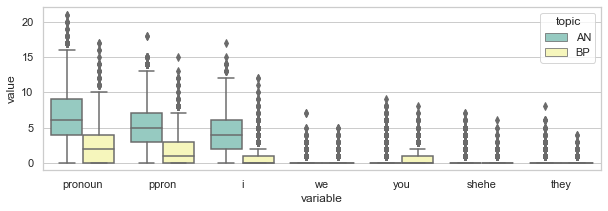

In [62]:
# Plot boxplots
import seaborn as sns
sns.set(rc={'figure.figsize':(10,3)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="variable", y="value", hue="topic", data=liwc_stats_sub, palette="Set3")

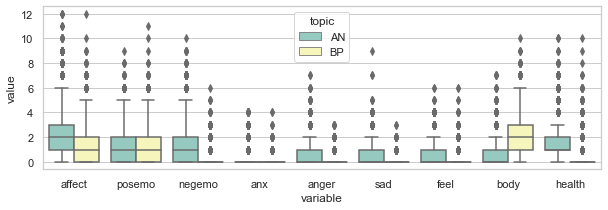

In [63]:
# Select topics of interest -- relevant to emotion
liwc_stats_sub = liwc_stats[liwc_stats.variable.isin(["affect","posemo","negemo","anx","anger","sad","feel","body","health"])]
ax = sns.boxplot(x="variable", y="value", hue="topic", data=liwc_stats_sub, palette="Set3")

In [64]:
# Comparing distributions using Mann-Whitney U test
# https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
stats.mannwhitneyu(liwc_stats[(liwc_stats.topic=="AN") & (liwc_stats.variable=="negemo")].value,
                   liwc_stats[(liwc_stats.topic=="BP") & (liwc_stats.variable=="negemo")].value)

MannwhitneyuResult(statistic=27927834.0, pvalue=0.0)

In [65]:
stats.mannwhitneyu(liwc_stats[(liwc_stats.topic=="AN") & (liwc_stats.variable=="posemo")].value,
                   liwc_stats[(liwc_stats.topic=="BP") & (liwc_stats.variable=="posemo")].value)

MannwhitneyuResult(statistic=17308427.0, pvalue=3.190741203838059e-17)

In [66]:
liwc_stats[(liwc_stats.topic=="AN") & (liwc_stats.variable=="anx")].value.describe()

count    11973.000000
mean         0.256744
std          0.549638
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: value, dtype: float64

In [67]:
liwc_stats[(liwc_stats.topic=="BP") & (liwc_stats.variable=="anx")].value.describe()

count    3184.000000
mean        0.048681
std         0.266141
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: value, dtype: float64